In [2]:
import pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from collections import Counter
import time
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
import feather
import random
from datetime import *
import warnings
warnings.filterwarnings("ignore")

In [30]:
FILENAME = "Datasets/final_datasets/merged_data"

In [20]:
data = feather.read_dataframe(f"{FILENAME}.feather")

In [21]:
# Remove those one-hot encoded columns in the dataset created by Abhi

def in_name(c, one_hots):
    for col_name in one_hots:
        if c.startswith(f"{col_name}_"):
            return True
    return False

one_hots = ['Wind_Direction', 'Timezone','State', 'Weather_Condition']
remove = [col for col in data.columns if in_name(col, one_hots)]
df = data.drop(remove, axis=1)


In [22]:
# Remove missing values
df = df.dropna().reset_index(drop=True)
print(len(df))

2921570


In [23]:
df['Severity'] = df['Severity'].astype(int)

# Clean categorical features

### Clean wind direction

* "CALM" = ["Calm", "CALM"]
* "W" = ["W", "West", "WSW", "WNW"] 
* "S" = ["S", "South", "SSW", "SSE"] 
* "N" = ["N", "North", "NNW", "NNE"] 
* "E" = ["E", "East", "ESE", "ENE"]
* "VAR" = ["VAR", "Variable"]

In [ ]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

### Clean weather condition

https://www.timeanddate.com/weather/glossary.html <br>

**Create features according the different weather conditions** <br>
Scattered clouds, partly cloudy = PARTLY CLOUDY <br>
Overcast, Mostly cloudly, Cloudy = CLOUDY <br>
Fair, Clear = CLEAR <br>
Snow (light snow, heavy snow), and wintry mix  = SNOW <br>
drizzle, light rain/drizzle, light freezing rain/drizzle = LIGHT RAIN <br>
Heavy Rain, heavy thunderstorms, heavy t-storm = HEAVY RAIN <br>
Haze, fog, mist, smoke = fog     *(see https://www.worldatlas.com/articles/what-are-the-differences-between-mist-haze-and-fog.html)*<br>
Rain, light thunderstorms, thunderstorms, t-storm, thunder = RAIN <br>

In [13]:
def get_condition(string):
    
    conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog'] 
    strings = [['clear', 'fair'],
              ['partly cloudy', 'scattered clouds'],
              ['overcast', 'mostly cloudy', 'cloudy'],
              ['snow', 'wintry mix', 'ice'],
              ['drizzle', 'light rain', 'light freezing rain'],
              ['heavy rain', 'heavy thunderstorms', 'heavy t-storm'],
              ['rain', 'thunderstorms', 't-storm', 'thunder', 'showers'],
              ['fog', 'haze', 'mist', 'smoke']]

    for j, k in enumerate(strings):
        for val in k:
            if val in string.lower():
                return conditions[j]
    return 'Others'

In [14]:
res = []
for i in df['Weather_Condition'].values:
    res.append(get_condition(i))

df['Condition'] = res

conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog', 'Others'] 

for i in conditions:
    print(i, ":")
    print(set(df[df['Condition']==i]['Weather_Condition']))
    print(sum(df['Condition']==i))
    print("\n")
    
df = df[df['Condition']!='Others']

Clear :
{'Clear', 'Fair / Windy', 'Fair'}
1128616


Partly Cloudy :
{'Partly Cloudy / Windy', 'Partly Cloudy', 'Scattered Clouds'}
479226


Cloudy :
{'Cloudy / Windy', 'Mostly Cloudy / Windy', 'Cloudy', 'Mostly Cloudy', 'Overcast'}
960533


Snow :
{'Snow', 'Light Snow / Windy', 'Snow / Windy', 'Light Snow', 'Heavy Snow', 'Blowing Snow', 'Wintry Mix'}
55888


Light Rain :
{'Light Rain', 'Drizzle', 'Light Rain / Windy', 'Light Freezing Drizzle', 'Light Freezing Rain', 'Drizzle and Fog', 'Heavy Drizzle', 'Light Drizzle', 'Light Rain with Thunder'}
168234


Heavy Rain :
{'Heavy Thunderstorms and Rain', 'Heavy T-Storm', 'Heavy Rain / Windy', 'Heavy Rain', 'Heavy T-Storm / Windy'}
17442


Rain :
{'Light Thunderstorms and Rain', 'Thunderstorm', 'Rain / Windy', 'T-Storm / Windy', 'Showers in the Vicinity', 'T-Storm', 'Thunderstorms and Rain', 'Rain', 'Thunder in the Vicinity', 'Thunder / Windy', 'Thunder'}
51435


Fog :
{'Mist', 'Haze / Windy', 'Patches of Fog', 'Smoke', 'Shallow Fog', 'Fog', 

In [12]:
# One hot encode ['Wind_Direction', 'Timezone', 'State', 'Condition']

one_hots = ['Wind_Direction', 'Timezone','State', 'Condition']
oh = pd.DataFrame()
for c in one_hots:
    dummies = pd.get_dummies(df[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

df = pd.concat([df, oh], axis=1)

In [13]:
# Save this dataframe
df.to_feather("{}_v1.feather".format(FILENAME))

In [6]:
df = feather.read_dataframe("{}_v1.feather".format(FILENAME))

#### With numeric attributes

In [7]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 
        'Wind_Direction', 'Timezone', 'State', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Roundabout', 'Give_Way', 'Traffic_Calming',
        "Wind_Direction"]

df = df.drop(drop, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_numeric_v2.feather".format(FILENAME))

In [8]:
del(df)

#### without numeric attributes

In [16]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 
        'Wind_Direction', 'Timezone', 'State', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Roundabout', 'Give_Way', 'Traffic_Calming',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

df = df.drop(drop, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_v2.feather".format(FILENAME))

# clears memory allocated to df
df = 0 

In [17]:
# Clear memory
del(df)

# Model

### Finding best neuron size

In [ ]:
data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
EPOCHS = 5
BATCH_SIZE = 128

# One hot encode labels
n = len(data)
labels = data['Severity']
y = np.zeros((n, 4))
for i in range(n):
    y[i, labels[i]-1] = 1
    
X = data.drop('Severity', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30034)

max_neurons = X_train.shape[1]
neuron_size = range(max_neurons,4,-10)

for i in neuron_size:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(i, activation=tf.nn.swish,input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(4, activation=tf.nn.sigmoid))

    # Compile and print out summary of model
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])
    
    
    print("==================================================")
    print("Number of Neurons: ",i)
    print("==================================================")
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    model.evaluate(X_test, y_test)

### Model evaluation with numeric

In [12]:
from sklearn.model_selection import StratifiedKFold

data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))
labels = data['Severity']
X = data.drop('Severity', axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]
    
    
    y_train = np.zeros((len(X_train), 4))
    for i in range(len(X_train)):
        y_train[i, labels[i]-1] = 1

    y_test = np.zeros((len(X_test), 4))
    for i in range(len(X_test)):
        y_test[i, labels[i]-1] = 1

    EPOCHS = 5
    BATCH_SIZE = 128

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(70, activation=tf.nn.swish,input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(4, activation=tf.nn.sigmoid))

    # Compile and print out summary of model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Epoch 1/5
1948266/1948266 [==============================] - 16s 8us/sample - loss: 0.6617 - acc: 0.6621
Epoch 2/5
1948266/1948266 [==============================] - 15s 8us/sample - loss: 0.6596 - acc: 0.6623
Epoch 3/5
1948266/1948266 [==============================] - 16s 8us/sample - loss: 0.6595 - acc: 0.6623
Epoch 4/5
1948266/1948266 [==============================] - 17s 8us/sample - loss: 0.6593 - acc: 0.6623
Epoch 5/5
974134/974134 [==============================] - 11s 12us/sample - loss: 0.6591 - acc: 0.6746
Accuracy: 0.6745663
FOLD NUMBER =  2
Epoch 1/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6345 - acc: 0.6642
Epoch 2/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6288 - acc: 0.6660
Epoch 3/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6271 - acc: 0.6669
Epoch 4/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6260 - acc: 0.6676
Ep

### Model evaluation without numeric

accuracy: 0.7001286613742129


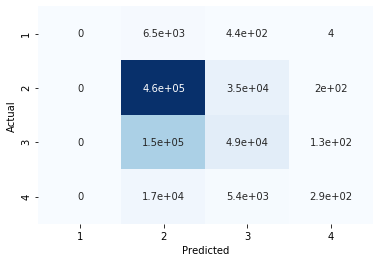

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

p = []
t = []
for i in y_preds:
    p.append(np.argmax(i)+1)

for i in y_test:
    t.append(np.argmax(i)+1)    

print("accuracy:", accuracy_score(t, p))

cm=confusion_matrix(t,p)
cm = pd.DataFrame(cm, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
sns.heatmap(cm, annot=True, 
            cmap='Blues', cbar=False)
plt.show()

In [13]:
from sklearn.model_selection import StratifiedKFold

data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
labels = data['Severity']
X = data.drop('Severity', axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]

    y_train = np.zeros((len(X_train), 4))
    for i in range(len(X_train)):
        y_train[i, labels[i]-1] = 1

    y_test = np.zeros((len(X_test), 4))
    for i in range(len(X_test)):
        y_test[i, labels[i]-1] = 1

    EPOCHS = 5
    BATCH_SIZE = 128

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(70, activation=tf.nn.swish,input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(4, activation=tf.nn.sigmoid))

    # Compile and print out summary of model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Epoch 1/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6620 - acc: 0.6621
Epoch 2/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6598 - acc: 0.6623
Epoch 3/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6596 - acc: 0.6623
Epoch 4/5
1948266/1948266 [==============================] - 14s 7us/sample - loss: 0.6595 - acc: 0.6623
Epoch 5/5
974134/974134 [==============================] - 11s 11us/sample - loss: 0.6592 - acc: 0.6746
Accuracy: 0.6745663
FOLD NUMBER =  2
Epoch 1/5
1948267/1948267 [==============================] - 15s 8us/sample - loss: 0.6369 - acc: 0.6635
Epoch 2/5
1948267/1948267 [==============================] - 16s 8us/sample - loss: 0.6327 - acc: 0.6642
Epoch 3/5
1948267/1948267 [==============================] - 17s 9us/sample - loss: 0.6321 - acc: 0.6645
Epoch 4/5
1948267/1948267 [==============================] - 16s 8us/sample - loss: 0.6317 - acc: 0.6646
Ep

In [24]:
# np.where makes values <= 2 equal 0, else 1 (essentially a more efficient way) 
data["Grouped_Severity"] = np.where(data['Severity']<=2, 0, 1)

In [30]:
from sklearn.model_selection import StratifiedKFold

labels = data['Grouped_Severity']
X = data.drop(['Severity',"Grouped_Severity"], axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]

    y_train = labels[train_index]
    y_test = labels[test_index]

    EPOCHS = 10
    BATCH_SIZE = 128

    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Epoch 1/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5305 - acc: 0.7190
Epoch 2/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5176 - acc: 0.7280
Epoch 3/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5127 - acc: 0.7323
Epoch 4/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5102 - acc: 0.7348
Epoch 5/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5087 - acc: 0.7358
Epoch 6/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5077 - acc: 0.7368
Epoch 7/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5067 - acc: 0.7377
Epoch 8/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5058 - acc: 0.7384
Epoch 9/10
1948266/1948266 [==============================] - 10s 5us/sample - loss: 0.5050 - acc: 0.7389
Epoch 10/10
974134/974134 [==

KeyboardInterrupt: 

# Numeric, grouped severity

In [31]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

data["Grouped_Severity"] = np.where(data['Severity']<=2, 0, 1)

In [32]:
from sklearn.model_selection import StratifiedKFold

labels = data['Grouped_Severity']
X = data.drop(['Severity',"Grouped_Severity"], axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=3, random_state=30034, shuffle=False)

fold_no = 1
accs = []  # store each accuracy


for train_index, test_index in skf.split(X, labels):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))


    X_train = X[train_index]
    X_test = X[test_index]

    y_train = labels[train_index]
    y_test = labels[test_index]

    EPOCHS = 10
    BATCH_SIZE = 128

    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(40, input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)
    print("============================================")
    fold_no+=1

FOLD NUMBER =  1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1947712/1947712 [==============================] - 34s 17us/sample - loss: 0.5308 - acc: 0.7191
Epoch 2/10
1947712/1947712 [==============================] - 38s 19us/sample - loss: 0.5186 - acc: 0.7268
Epoch 3/10
1947712/1947712 [==============================] - 41s 21us/sample - loss: 0.5141 - acc: 0.7304
Epoch 4/10
1947712/1947712 [==============================] - 40s 20us/sample - loss: 0.5116 - acc: 0.7330
Epoch 5/10
1947712/1947712 [==============================] - 40s 20us/sample - loss: 0.5097 - acc: 0.7349
Epoch 6/10
1947712/1947712 [==============================] - 41s 21us/sample - loss: 0.5083 - acc: 0.7363
Epoch 7/10
1947712/1947712 [==============================] - 40s 21us/sample - loss: 0.5071 - acc: 0.7373
Epoch 8/10
 813184/1947712 [===========>..................] - ETA: 26s - loss: 0.5061 - acc: 0.7374

KeyboardInterrupt: 